In [4]:
import uproot
import awkward as ak

In [2]:
truth = uproot.open("4tops_skimmed_14nov.root:Truth")
reco = uproot.open("4tops_skimmed_14nov.root:Reco")

In [22]:
# get only all-hadronic events
truth_hadronic = ak.count_nonzero(abs(truth["W_decay_id"].array())<6,axis=1)==8

In [23]:
reco_hadronic = (ak.count(reco["el_pt"].array(),axis=1) + ak.count(reco["mu_pt"].array(),axis=1))==0

In [25]:
allhad_mask = truth_hadronic * reco_hadronic

In [38]:
import vector
truth_Bs = vector.zip({"pt":truth["b_pt"].array(),
           "eta":truth["b_eta"].array(),
           "phi":truth["b_phi"].array(),
           "e":truth["b_e"].array()})[allhad_mask][:,-4:]

In [61]:
truth_W_decays = vector.zip({"pt":truth["W_decay_pt"].array(),
           "eta":truth["W_decay_eta"].array(),
           "phi":truth["W_decay_phi"].array(),
           "e":truth["W_decay_e"].array()})[allhad_mask]

In [174]:
type(truth_W_decays)

vector.backends.awkward.MomentumArray4D

In [64]:
truth_objects = ak.concatenate([truth_Bs,truth_W_decays],axis=1)

In [42]:
btagged_mask = reco["jet_btag"].array()==1

In [46]:
all_jets = vector.zip({"pt":reco["jet_pt"].array(),
           "eta":reco["jet_eta"].array(),
           "phi":reco["jet_phi"].array(),
           "m":reco["jet_mass"].array()})[allhad_mask]

In [49]:
bjets = all_jets[btagged_mask[allhad_mask]]

In [51]:
def jet_matching(truth_vectors, reco_jets, delta_r_threshold=0.4):
    """
    Match reco_jets to truth_vectors based on delta-R criteria.
    Each jet can be matched to at most one truth particle (closest match).

    Parameters:
        truth_vectors: list of vector objects (truth particles)
        reco_jets: list of vector objects (reconstructed jets)
        delta_r_threshold: float, the delta-R threshold for matching (default 0.4)

    Returns:
        list: A list of indices where each element corresponds to the index of the
              matched truth_vector for the reco_jet at the same position.
              If no match is found for a reco_jet, the value is None.
    """
    matches = [None] * len(reco_jets)  # Initialize all matches as None
    matched_truths = set()  # Keep track of already matched truth particles

    for j, jet in enumerate(reco_jets):
        # Compute delta-R for this jet against all truth particles
        delta_rs = [jet.deltaR(truth) if i not in matched_truths else float("inf")
                    for i, truth in enumerate(truth_vectors)]
        
        # Find the closest truth particle within the delta-R threshold
        min_delta_r = min(delta_rs, default=float("inf"))
        if min_delta_r <= delta_r_threshold:
            closest_truth_index = delta_rs.index(min_delta_r)
            matches[j] = closest_truth_index
            matched_truths.add(closest_truth_index)  # Mark the truth particle as matched

    return matches


In [231]:
from tqdm import tqdm 

l = []
for i in tqdm(range(10000)):
    l.append(jet_matching(truth_objects[i],all_jets[i]))
    
    
truth_tops = []
reco_tops  = []
for e in range(len(l)):
    print(e)
    if set([0,4,5])<=set(l[e]):
        truth_tops.append(truth_objects[e,0]+truth_objects[e,4]+truth_objects[e,5])
        reco_indices = [l[e].index(elem) for elem in [0,4,5]]
        reco_tops.append(all_jets[e,reco_indices[0]]+all_jets[e,reco_indices[1]]+all_jets[e,reco_indices[2]])
        
    if set([1,6,7])<=set(l[e]):
        truth_tops.append(truth_objects[e,1]+truth_objects[e,6]+truth_objects[e,7])
        reco_indices = [l[e].index(elem) for elem in [1,6,7]]
        reco_tops.append(all_jets[e,reco_indices[0]]+all_jets[e,reco_indices[1]]+all_jets[e,reco_indices[2]])
        
    if set([2,8,9])<=set(l[e]):
        truth_tops.append(truth_objects[e,2]+truth_objects[e,8]+truth_objects[e,9])
        reco_indices = [l[e].index(elem) for elem in [2,8,9]]
        reco_tops.append(all_jets[e,reco_indices[0]]+all_jets[e,reco_indices[1]]+all_jets[e,reco_indices[2]])
        
    if set([3,10,11])<=set(l[e]):
        truth_tops.append(truth_objects[e,3]+truth_objects[e,10]+truth_objects[e,11])
        reco_indices = [l[e].index(elem) for elem in [3,10,11]]
        reco_tops.append(all_jets[e,reco_indices[0]]+all_jets[e,reco_indices[1]]+all_jets[e,reco_indices[2]])

    

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [14:59<00:00, 11.12it/s]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [258]:
len(l)

10000

In [222]:
truth_tops = []
reco_tops  = []
for e in range(len(l)):
    print(e)
    if set([0,4,5])<=set(l[e]):
        truth_tops.append(truth_objects[e,0]+truth_objects[e,4]+truth_objects[e,5])
        reco_indices = [l[e].index(elem) for elem in [0,4,5]]
        reco_tops.append(all_jets[e,reco_indices[0]]+all_jets[e,reco_indices[1]]+all_jets[e,reco_indices[2]])
        
    if set([1,6,7])<=set(l[e]):
        truth_tops.append(truth_objects[e,1]+truth_objects[e,6]+truth_objects[e,7])
        reco_indices = [l[e].index(elem) for elem in [1,6,7]]
        reco_tops.append(all_jets[e,reco_indices[0]]+all_jets[e,reco_indices[1]]+all_jets[e,reco_indices[2]])
        
    if set([2,8,9])<=set(l[e]):
        truth_tops.append(truth_objects[e,2]+truth_objects[e,8]+truth_objects[e,9])
        reco_indices = [l[e].index(elem) for elem in [2,8,9]]
        reco_tops.append(all_jets[e,reco_indices[0]]+all_jets[e,reco_indices[1]]+all_jets[e,reco_indices[2]])
        
    if set([3,10,11])<=set(l[e]):
        truth_tops.append(truth_objects[e,3]+truth_objects[e,10]+truth_objects[e,11])
        reco_indices = [l[e].index(elem) for elem in [3,10,11]]
        reco_tops.append(all_jets[e,reco_indices[0]]+all_jets[e,reco_indices[1]]+all_jets[e,reco_indices[2]])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [256]:
[[4,7,5,6,8,0,1].index(elem) for elem in [0,4,5]]

[5, 0, 2]

In [234]:
import vector
vector.register_awkward()

px = ak.Array([vec.px for vec in reco_tops])
py = ak.Array([vec.py for vec in reco_tops])
pz = ak.Array([vec.pz for vec in reco_tops])
E = ak.Array([vec.E for vec in reco_tops])

# Create an awkward array with these components
reco_tops_vector = vector.zip({"px": px, "py": py, "pz": pz, "E": E})


tpx = ak.Array([vec.px for vec in truth_tops])
tpy = ak.Array([vec.py for vec in truth_tops])
tpz = ak.Array([vec.pz for vec in truth_tops])
tE = ak.Array([vec.E for vec in truth_tops])

# Create an awkward array with these components
truth_tops_vector = vector.zip({"px": tpx, "py": tpy, "pz": tpz, "E": tE})



In [244]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200


Text(0.5, 1.0, 'Top $p_T$ in 4tops 0L channel')

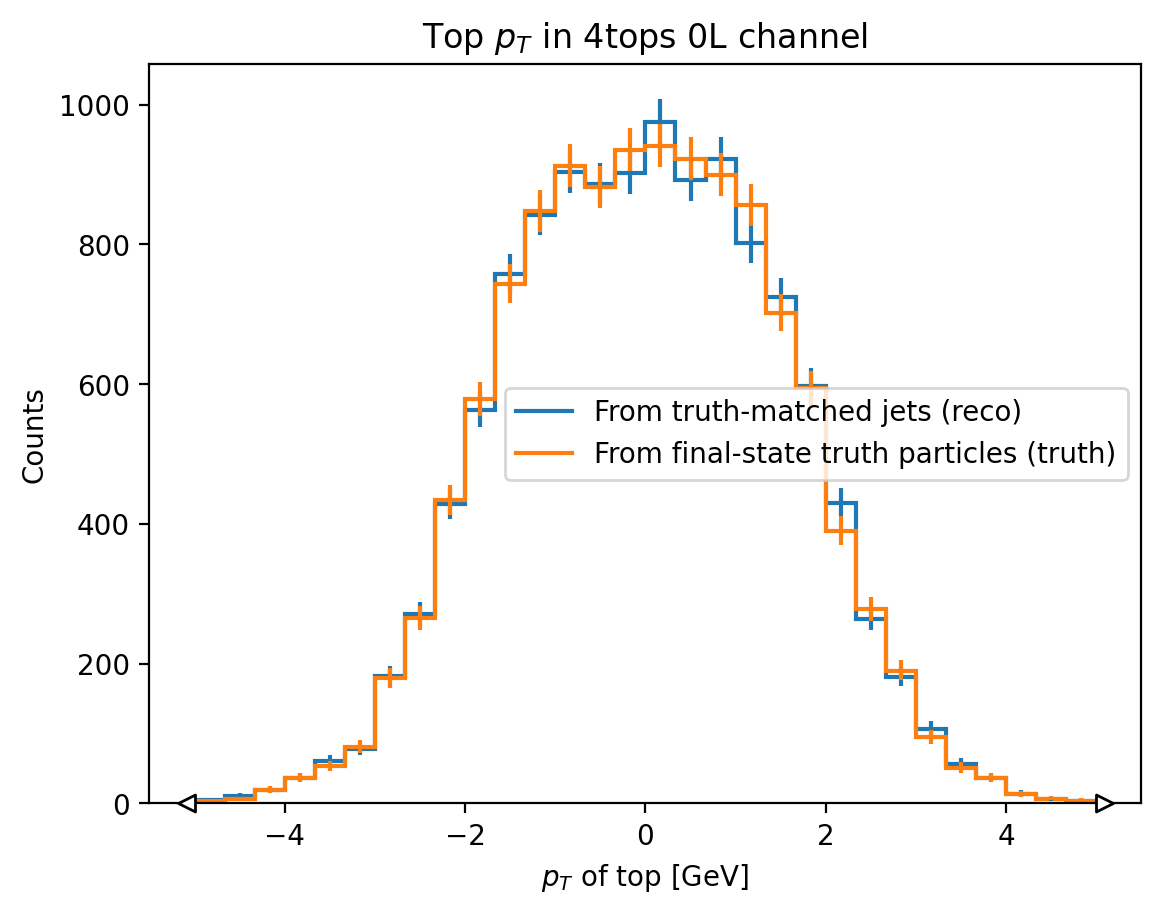

In [254]:
import mplhep as hep 
import boost_histogram as bh 

hist_reco = bh.Histogram(bh.axis.Regular(30, -5, 5))
hist_reco.fill(reco_tops_vector.eta)

hist_truth = bh.Histogram(bh.axis.Regular(30, -5, 5))
hist_truth.fill(truth_tops_vector.eta)

hep.histplot([hist_reco,hist_truth])
plt.xlabel(r"$p_T$ of top [GeV]")
plt.ylabel(r"Counts")
plt.legend([r"From truth-matched jets (reco)", "From final-state truth particles (truth)"])
plt.title(r"Top $p_T$ in 4tops 0L channel")

In [207]:
awkward_array.m

<Array [169, 122, 192, 159, 168, ..., 198, 139, 140, 168] type='955 * float64'>

In [146]:
b1 = truth_objects[6,0]
w1 = truth_objects[6,4]
w2 = truth_objects[6,5]

In [145]:
b2 = all_jets[6,5]
w3 = all_jets[6,6]
w4 = all_jets[6,7]

In [147]:
truth_top = (b1 + w1 + w2)

In [148]:
reco_top = (b2 + w3 + w4)

In [149]:
truth_top.m

169.9694575324588

In [150]:
reco_top.m

191.97719

In [118]:
all_jets[2]

<MomentumArray4D [{rho: 120, phi: 0.619, ...}, ...] type='12 * Momentum4D[r...'>

In [144]:
truth_objects[6]

<MomentumArray4D [{rho: 73.1, phi: 1.78, ...}, ...] type='12 * Momentum4D[r...'>

In [164]:
for e in range(len(l)):
    print(e)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27